Импорт библиотек

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import trim_mean, skew, kurtosis, norm

# === Класс распределения Хьюбера ===
import mpmath as mp
from mpmath import quad
from scipy.optimize import brentq
from scipy.stats import norm

Класс распределения Хьюбера
$$f(x, \nu) = \frac{1 - \nu}{\sqrt{2\pi}} 
\begin{cases}
\exp\left(-\frac{x^2}{2}\right), & |x| \leq k \\
\exp\left(\frac{1}{2}k^2 - k|x|\right), & |x| > k
\end{cases}$$

где $0 < v < 1$ - параметр формы, вспомогательный параметр $k > 0$ связан с $v$ условием нормировки плотности
$$ 
\frac{2}{k} \phi(k) + 2 \left[ \Phi(k) - 1 \right] = \frac{\nu}{1 - \nu}
$$

$\Phi(k)$ и $\phi(k)$ - функция и плотность стандартного нормального распределения.

Дисперсия определяется формулой $$\sigma^2 = 1 + \frac{2\phi(k)(k^2 + 2)}{2k^2\phi(k) + k^3\left[2\Phi(k) - 1\right]}
$$

Коэффициент эксцесса определяется формулой $$ \gamma_2 = \frac{1}{\sigma^4} \left[ \frac{3(2\Phi(k) - 1) + 2\phi(k)\left( \dfrac{24}{k^5} + \dfrac{24}{k^3} + \dfrac{12}{k} + k \right)}{2\phi(k)/k + 2\Phi(k) - 1} \right] - 3 $$

Вероятность попадания в центральный интервал $$P = \frac{2(1 - \nu)}{k} f(k, \nu)$$

Алгоритм моделирования случайной величины

Шаг 1. Получить реализацию $r_{1}$ случайной величины, равномерно распределенной на интервале (0, 1). Если $r_{1} <= P$, перейти на шаг 2, иначе перейти на шаг 4.

Шаг 2. Получить реализацию $x_{1}$ нормальной случайной величины (способ её моделирования см. в пп. 1).

Шаг 3. Если $x_{1}$ принадлежит интервалу $[-k, k]$, то это реализация целевой случайной величины, иначе перейти на шаг 2.

Шаг 4. Получить реализацию $r_{2}$ случайной величины, равномерно распределенной на интервале (0, 1). Вычислить $$ x_2 = k - \frac{\ln r_2}{k}$$

Шаг 5. Если $r_{1} < \frac{1 + P}{2}$, то $x_{2}$ - реализация целевой случайной величины, иначе реализацией целевой случайной величины является $-x_{2}$

<b>Замечание 1.</b>
Для повышения точности вычисляемых теоретических характеристик вычисление производим через 2 и 4 моменты распределения по формуле

$$m_n = \int_{-\infty}^{+\infty} x^n f(x) \, dx$$

<p>В данном случае дисперсия $D[X] = \sigma^{2} * m_2 = m_2$, поскольку масштаб стандартного распределения $\sigma = 1$</p>
<p>А коэффициент эксцесса $\gamma_{4} = m_{4} / m_{2}^{2} - 3$

<b>Замечание 2.</b> Поскольку распределение Хьюбера является симметричным, достаточно вычислять моменты по положительной полуоси (в центральной части на интервале $[0, k]$, в хвосте на интервале $[k, \infty]$), а затем домножать полученное значение на 2

<b>Замечание 3.</b> Поскольку распределение Хьюбера, как и все представленные в остальных вариантах, является унимодальным, то
<p>Мат. ожидание $E[X] = \mu$ (В случае стандартного распределения $\mu = 0$)</p>
<p>Коэффициент асимметрии $\gamma_{3} = 0$</p>

In [19]:
class HuberDistribution:
    def __init__(self, v: float, mu: float = 0.0, sigma: float = 1.0):
        if not (0.0 < v < 1.0):
            raise ValueError("v must be in (0,1)")
        if sigma <= 0:
            raise ValueError("sigma must be > 0")
        self.v = float(v)
        self.mu = float(mu)
        self.sigma = float(sigma)

    def _solve_k(self):
        def eq(k):
            return 2.0 * norm.pdf(k) / k + 2.0 * (norm.cdf(k) - 1.0) - self.v / (1.0 - self.v)
        return float(brentq(eq, 1e-8, 20.0))

    def k(self): 
        return self._solve_k()

    def pdf(self, x: float) -> float:
        """PDF с учётом mu и sigma"""
        k = self.k()
        coeff = (1.0 - self.v) / (self.sigma * np.sqrt(2.0 * np.pi))
        z = (x - self.mu) / self.sigma
        if abs(z) <= k:
            return coeff * np.exp(-0.5 * z**2)
        else:
            return coeff * np.exp(0.5 * k**2 - k * abs(z))

    def P(self):
        k = mp.mpf(self.k())
        v_mp = mp.mpf(self.v)
        coeff = (1 - v_mp) / mp.sqrt(2 * mp.pi)
        return float(quad(lambda t: coeff * mp.e**(-0.5 * t**2), [-k, k]))

    def _moment(self, n: int) -> float:
        """Моменты стандартизованного распределения (mu=0, sigma=1)."""
        k = mp.mpf(self.k())
        v_mp = mp.mpf(self.v)
        coeff = (1 - v_mp) / mp.sqrt(2 * mp.pi)

        def central(t): return (t**n) * coeff * mp.e**(-0.5 * t**2)
        def tail(t): return (t**n) * coeff * mp.e**(0.5 * k**2 - k*t)

        I1 = quad(central, [0, k])
        I2 = quad(tail, [k, mp.inf])
        return float(2 * (I1 + I2))

    # === Теоретические характеристики ===
    def mean(self): 
        return self.mu  # симметрия распределения

    def variance(self): 
        return (self.sigma**2) * self._moment(2)

    def skewness(self): 
        return 0.0  # симметрия

    def excess_kurtosis(self):
        m2 = self._moment(2)
        m4 = self._moment(4)
        return m4 / m2**2 - 3

    # === Генерация выборки ===
    def sample(self, size=1, random_state=None):
        rng = np.random.default_rng(random_state)
        k, P = self.k(), self.P()
        samples, normal_buffer = [], []

        def next_normal():
            if normal_buffer:
                return normal_buffer.pop()
            u1, u2 = rng.uniform(), rng.uniform()
            r = np.sqrt(-2.0 * np.log(u1))
            z1, z2 = r*np.cos(2*np.pi*u2), r*np.sin(2*np.pi*u2)
            normal_buffer.append(z2)
            return z1

        for _ in range(size):
            r1 = rng.uniform()
            if r1 <= P:  # центр
                while True:
                    x1 = next_normal()
                    if abs(x1) <= k:
                        samples.append(x1)
                        break
            else:  # хвост
                r2 = rng.uniform()
                x2 = k - np.log(r2)/k
                samples.append(x2 if r1 <= (1+P)/2 else -x2)

        # масштабируем и сдвигаем
        return self.mu + self.sigma * np.array(samples)

### Чистое распределение Хьюбера

In [20]:
# === Генерация данных ===
def pure_huber(N, v=0.3, mu=0.0, sigma=1.0, random_state=None):
    huber = HuberDistribution(v, mu, sigma)
    return huber.sample(size=N, random_state=random_state)

### Засоренное распределение Хьюбера

In [21]:
def contaminated_huber(N, v=0.3, mu=0.0, sigma=1.0, eps=0.2, noise_level=20.0, random_state=None):
    """10-30% наблюдений заменяем выбросами"""
    rng = np.random.default_rng(random_state)
    n_cont = int(N * eps)
    n_clean = N - n_cont
    clean = pure_huber(n_clean, v, mu, sigma, random_state=rng)
    contam = pure_huber(n_cont, v, mu, sigma * noise_level, random_state=rng)
    return np.concatenate([clean, contam])

### Выборочные характеристики распределения Хьюбера по выборке
<p><b>mean</b> - математическое ожидание (среднее)</p>
<p><b>var</b> - дисперсия</p>
<p><b>skew</b> - асимметрия</p>
<p><b>kurtosis</b> - коэффициент эксцесса</p>
<p><b>median</b> - медиана</p>
<p><b>trim_mean_0.05/0.10/0.15</b> - усеченное среднее для $\alpha = [0.05, 0.10, 0.15]$</p>

In [22]:
# === Выборочные характеристики ===
def sample_characteristics(data):
    return {
        "mean": np.mean(data),
        "var": np.var(data, ddof=1),
        "skew": skew(data),
        "kurtosis": kurtosis(data, fisher=True),
        "median": np.median(data),
        "trim_mean_0.05": trim_mean(data, 0.05),
        "trim_mean_0.10": trim_mean(data, 0.10),
        "trim_mean_0.15": trim_mean(data, 0.15),
    }

### Функция эксперимента
Генерирование выборок для чистого и засоренного распределения Хьюбера, а также вычисление теоретических характеристик

In [23]:
# === Эксперимент ===
def experiment(N=500, v=0.3, eps=0.2, noise_level=20.0, random_state=42):
    rng = np.random.default_rng(random_state)
    huber = HuberDistribution(v, mu=0.0, sigma=1.0)

    datasets = {
        "pure": pure_huber(N, v=v, mu=0.0, sigma=1.0, random_state=rng),
        "contaminated": contaminated_huber(N, v=v, mu=0.0, sigma=1.0, noise_level=noise_level, eps=eps, random_state=rng),
    }

    results = {name: sample_characteristics(data) for name, data in datasets.items()}

    # Добавляем теоретические значения
    theoretical = {
        "mean": huber.mean(),
        "var": huber.variance(),
        "skew": huber.skewness(),
        "kurtosis": huber.excess_kurtosis(),
    }

    return results, datasets, theoretical

### Функция построения графиков функций влияния среднего, медианы и усечённых средних

In [24]:
def influence_functions(mu=0.0, sigma=1.0, alpha_list=[0.05, 0.10, 0.15]):
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 500)

    # Среднее
    IF_mean = x - mu

    # Медиана
    f_mu = norm.pdf(mu, loc=mu, scale=sigma)  # плотность в медиане
    IF_median = np.sign(x - mu) / (2 * f_mu)

    # Усечённые средние
    IF_trimmed = {}
    for alpha in alpha_list:
        lower = norm.ppf(alpha, loc=mu, scale=sigma)
        upper = norm.ppf(1 - alpha, loc=mu, scale=sigma)
        IF = np.zeros_like(x)
        mask = (x >= lower) & (x <= upper)
        IF[mask] = (x[mask] - mu) / (1 - 2*alpha)
        IF_trimmed[alpha] = IF

    # --- Построение графиков ---
    plt.figure(figsize=(10, 6))
    plt.plot(x, IF_mean, label="Среднее")
    plt.plot(x, IF_median, label="Медиана")
    for alpha, IF in IF_trimmed.items():
        plt.plot(x, IF, label=f"Усечённое среднее α={alpha}")
    plt.legend()
    plt.title("Функции влияния оценок параметра сдвига")
    plt.xlabel("x")
    plt.ylabel("IF(x)")
    plt.grid(True)
    plt.show()

### Функция для вывода теоретических и фактических характеристик распределения

In [25]:
def print_distribution_info(results, theoretical):
    print("\n=== THEORETICAL VALUES (Huber) ===")
    for k, v in theoretical.items():
        print(f"  {k:15s} = {v:.4f}")

    for dist_name, ests in results.items():
        print(f"\n{dist_name.upper()} (sample estimates):")
        for k, v in ests.items():
            print(f"  {k:15s} = {v:.4f}")

### Функция для построения графиков чистых и засоренных распределений

In [26]:
def visualize(datasets):
    plt.figure(figsize=(10, 6))
    for name, data in datasets.items():
        plt.hist(data, bins=50, density=True, alpha=0.5, label=name)
    plt.legend()
    plt.title("Гистограммы: Хьюбер (чистое и искажённое распределение)")
    plt.show()

### Вариант 7
<b>Распределение Хьюбера</b> со значениями параметра $v = [0.002, 0.01, 0.05]$

Положим 
1. Параметр $v = 0.002$,
2. Засорение 10% выборки ($\epsilon = 0.1$)
3. Уровень засорения = масштаб (scale) * 5
4. Объём выборки $N = 5000$

In [27]:
results1, datasets1, theoretical1 = experiment(N=5000, v=0.002, eps=0.1, noise_level=5.0, random_state=1)

In [28]:
print_distribution_info(results1, theoretical1)


=== THEORETICAL VALUES (Huber) ===
  mean            = 0.0000
  var             = 1.0225
  skew            = 0.0000
  kurtosis        = 0.1859

PURE (sample estimates):
  mean            = 0.0199
  var             = 1.0076
  skew            = -0.0167
  kurtosis        = 0.2118
  median          = 0.0228
  trim_mean_0.05  = 0.0207
  trim_mean_0.10  = 0.0206
  trim_mean_0.15  = 0.0224

CONTAMINATED (sample estimates):
  mean            = 0.0142
  var             = 3.4882
  skew            = -0.3370
  kurtosis        = 15.6301
  median          = 0.0309
  trim_mean_0.05  = 0.0234
  trim_mean_0.10  = 0.0259
  trim_mean_0.15  = 0.0269


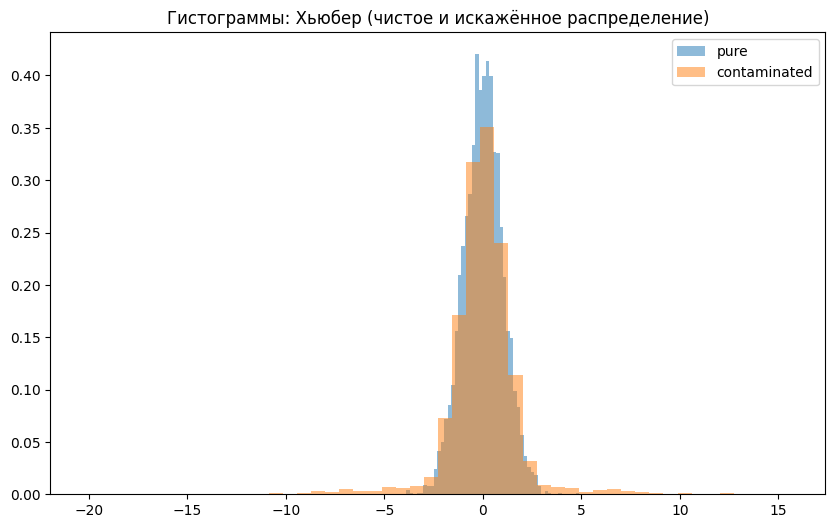

In [29]:
# Визуализация
visualize(datasets1)

Положим 
1. Параметр $v = 0.01$,
2. Засорение 20% выборки ($\epsilon = 0.2$)
3. Уровень засорения = масштаб (scale) * 15
4. Объём выборки $N = 10000$

In [30]:
results2, datasets2, theoretical2 = experiment(N=10000, v=0.01, eps=0.2, noise_level=15.0, random_state=1)

In [31]:
print_distribution_info(results2, theoretical2)


=== THEORETICAL VALUES (Huber) ===
  mean            = 0.0000
  var             = 1.0936
  skew            = 0.0000
  kurtosis        = 0.5736

PURE (sample estimates):
  mean            = 0.0148
  var             = 1.0994
  skew            = 0.0245
  kurtosis        = 0.6344
  median          = 0.0112
  trim_mean_0.05  = 0.0134
  trim_mean_0.10  = 0.0119
  trim_mean_0.15  = 0.0111

CONTAMINATED (sample estimates):
  mean            = 0.0076
  var             = 50.0882
  skew            = 0.0116
  kurtosis        = 12.3087
  median          = 0.0182
  trim_mean_0.05  = -0.0016
  trim_mean_0.10  = 0.0016
  trim_mean_0.15  = 0.0033


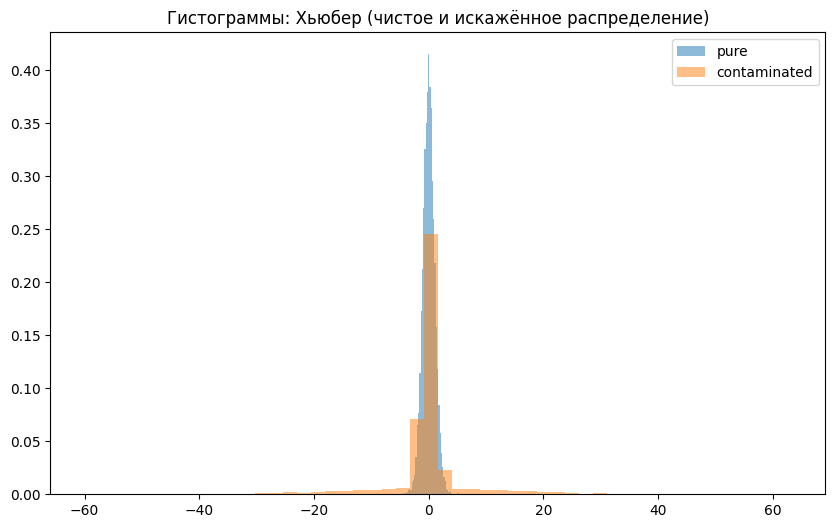

In [32]:
visualize(datasets2)

Положим 
1. Параметр $v = 0.05$,
2. Засорение 30% выборки ($\epsilon = 0.3$)
3. Уровень засорения = масштаб (scale) * 50
4. Объём выборки $N = 7000$

In [33]:
results3, datasets3, theoretical3 = experiment(N=7000, v=0.05, eps=0.3, noise_level=50.0, random_state=1)

In [34]:
print_distribution_info(results3, theoretical3)


=== THEORETICAL VALUES (Huber) ===
  mean            = 0.0000
  var             = 1.4124
  skew            = 0.0000
  kurtosis        = 1.5194

PURE (sample estimates):
  mean            = -0.0166
  var             = 1.4183
  skew            = -0.0600
  kurtosis        = 2.1046
  median          = -0.0130
  trim_mean_0.05  = -0.0135
  trim_mean_0.10  = -0.0138
  trim_mean_0.15  = -0.0129

CONTAMINATED (sample estimates):
  mean            = -0.2666
  var             = 1062.1726
  skew            = -0.1945
  kurtosis        = 10.8220
  median          = -0.0007
  trim_mean_0.05  = -0.0074
  trim_mean_0.10  = 0.0534
  trim_mean_0.15  = -0.0140


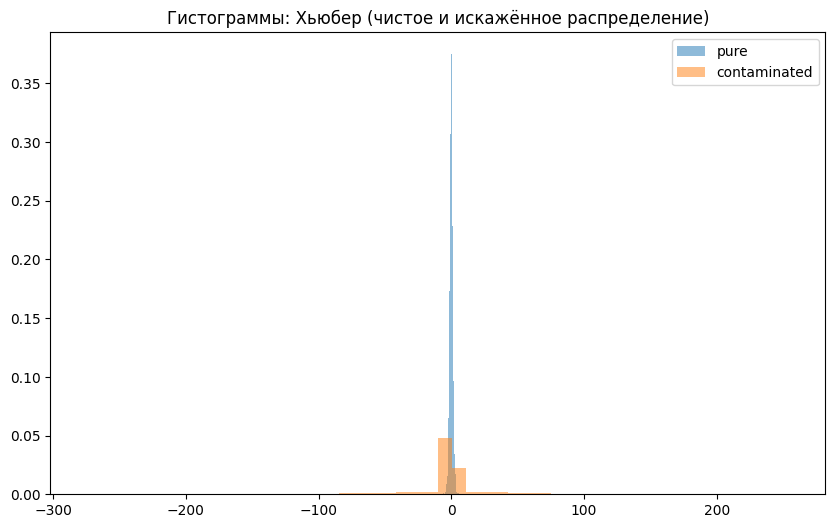

In [35]:
visualize(datasets3)

### Графики функций влияния для среднего арифметического, выборочной медианы и урезанных средних

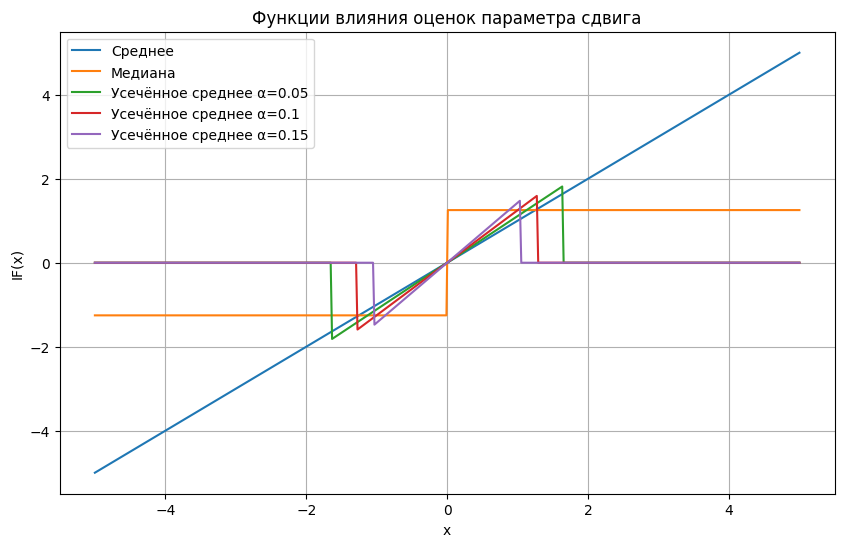

In [36]:
influence_functions()